In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/PROJECT - NLP/semantic-segmentation/data/text/files

/content/drive/My Drive/PROJECT - NLP/semantic-segmentation/data/text/files


In [0]:
import os
import io
import re
import pandas as pd

In [0]:
df = pd.read_csv('file2.csv')

In [0]:
df_1 = df[df['isLong'] == False]

In [0]:
df_1['Label'].value_counts()

3    3618
1    2215
2    1463
0     840
6     628
4     313
5     262
Name: Label, dtype: int64

In [0]:
df_2 = df_1.loc[(df_1['Label'] >= 0) & (df['Label'] <= 3)]

In [0]:
df_2['Label'].value_counts()

3    3618
1    2215
2    1463
0     840
Name: Label, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
sentences,sentences1,labels,labels1 = train_test_split(df_2.Sentence.values,df_2.Label.values,test_size=0.1)

In [0]:
len(labels) == len(sentences)

True

In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 4.7MB/s 
     |████████████████████████████████| 3.7MB 21.6MB/s 
     |████████████████████████████████| 890kB 35.1MB/s 
     |████████████████████████████████| 1.0MB 51.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=28f39ef9cde5649f3ca184948cc015b4c7b3a9ba81f2d889d50f52cb89d40b24
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len,len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  220


In [0]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [0]:
device

device(type='cuda')

In [0]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  In the case of Punamchandra Revashankar Joshi v
Token IDs: tensor([  101,  1999,  1996,  2553,  1997, 26136,  3286, 14856,  7265,  7065,
        11823,  2319,  6673, 26645,  1058,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [0]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,589 training samples
  733 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False
)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = total_steps)

In [0]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
CUDA_LAUNCH_BLOCKING=1

In [0]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of    206.    Elapsed: 0:00:09.
  Batch    80  of    206.    Elapsed: 0:00:17.
  Batch   120  of    206.    Elapsed: 0:00:25.
  Batch   160  of    206.    Elapsed: 0:00:33.
  Batch   200  of    206.    Elapsed: 0:00:41.

  Average training loss: 1.03
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 0.62
  Validation Loss: 0.93
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    206.    Elapsed: 0:00:08.
  Batch    80  of    206.    Elapsed: 0:00:16.
  Batch   120  of    206.    Elapsed: 0:00:25.
  Batch   160  of    206.    Elapsed: 0:00:33.
  Batch   200  of    206.    Elapsed: 0:00:41.

  Average training loss: 0.83
  Training epcoh took: 0:00:42

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.86
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    206.    Elapsed: 0:00:08.
  Batch    80  of    206.    Elapsed: 0:00:16.
  Batch   120  of    206.    Elapsed: 0:00:2

In [0]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.03,0.93,0.62,0:00:43,0:00:01
2,0.83,0.86,0.66,0:00:42,0:00:01
3,0.67,0.87,0.66,0:00:42,0:00:01
4,0.57,0.88,0.65,0:00:42,0:00:01


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


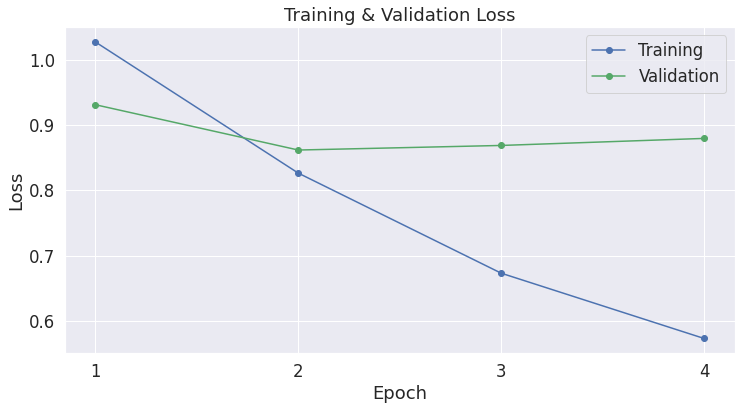

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [0]:
preds_labels = []
l = len(input_ids)
for i in range(l):
  t = model(input_ids[i].unsqueeze(0).cuda(), attention_mask=attention_masks[i].unsqueeze(0).cuda(),labels=labels[i].unsqueeze(0).cuda())[1]
  preds_labels.append(np.argmax(t.detach().cpu().numpy()))

In [0]:
from sklearn.metrics import classification_report
dic = classification_report(labels,preds_labels, labels=[0,1,2,3], target_names=['Argument', 'Facts', 'Precedent', 'Ratio of the decision'], digits=2, output_dict=True, zero_division='warn')
print(dic)
df_report = pd.DataFrame(data = dic)

{'Argument': {'precision': 0.8387096774193549, 'recall': 0.5880952380952381, 'f1-score': 0.6913925822253324, 'support': 840}, 'Facts': {'precision': 0.8572635135135135, 'recall': 0.9164785553047404, 'f1-score': 0.8858826096443378, 'support': 2215}, 'Precedent': {'precision': 0.7616191904047976, 'recall': 0.6944634313055366, 'f1-score': 0.726492670718627, 'support': 1463}, 'Ratio of the decision': {'precision': 0.8176853055916775, 'recall': 0.8689883913764511, 'f1-score': 0.8425566126222699, 'support': 3618}, 'accuracy': 0.8215339233038348, 'macro avg': {'precision': 0.8188194217323359, 'recall': 0.7670064040204916, 'f1-score': 0.7865811188026418, 'support': 8136}, 'weighted avg': {'precision': 0.8205493021948868, 'recall': 0.8215339233038348, 'f1-score': 0.8178746744297211, 'support': 8136}}


In [0]:
df_report

,Argument,Facts,Precedent,Ratio of the decision,accuracy,macro avg,weighted avg
precision,0.84,0.86,0.76,0.82,0.82,0.82,0.82
recall,0.59,0.92,0.69,0.87,0.82,0.77,0.82
f1-score,0.69,0.89,0.73,0.84,0.82,0.79,0.82
support,840.00,2215.00,1463.00,3618.00,0.82,8136.00,8136.00


In [0]:
input_ids = []
attention_masks = []

for sent in sentences1:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 100,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels1)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  In the case of Punamchandra Revashankar Joshi v
Token IDs: tensor([  101,  2009,  2052,  1010,  3568,  1010,  2025,  2022, 22945,  2000,
         2202,  2039,  1996,  4994,  1997,  2122,  5609,  2077,  1996,  2457,
        14572,  2005,  1996,  2146, 10885,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [0]:
preds_labels = []
l = len(input_ids)
for i in range(l):
  t = model(input_ids[i].unsqueeze(0).cuda(), attention_mask=attention_masks[i].unsqueeze(0).cuda(),labels=labels[i].unsqueeze(0).cuda())[1]
  preds_labels.append(np.argmax(t.detach().cpu().numpy()))

In [0]:
from sklearn.metrics import classification_report
dic = classification_report(labels,preds_labels, labels=[0,1,2,3], target_names=['Argument', 'Facts', 'Precedent', 'Ratio of the decision'], digits=2, output_dict=True, zero_division='warn')
print(dic)
df_report = pd.DataFrame(data = dic)

{'Argument': {'precision': 0.7021276595744681, 'recall': 0.39759036144578314, 'f1-score': 0.5076923076923077, 'support': 83}, 'Facts': {'precision': 0.6887966804979253, 'recall': 0.7443946188340808, 'f1-score': 0.7155172413793104, 'support': 223}, 'Precedent': {'precision': 0.5892857142857143, 'recall': 0.4782608695652174, 'f1-score': 0.5279999999999999, 'support': 138}, 'Ratio of the decision': {'precision': 0.6884057971014492, 'recall': 0.7702702702702703, 'f1-score': 0.7270408163265307, 'support': 370}, 'accuracy': 0.6756756756756757, 'macro avg': {'precision': 0.6671539628648893, 'recall': 0.5976290300288378, 'f1-score': 0.6195625913495373, 'support': 814}, 'weighted avg': {'precision': 0.6731078980278662, 'recall': 0.6756756756756757, 'f1-score': 0.6677738432516759, 'support': 814}}


In [0]:
df_report

,Argument,Facts,Precedent,Ratio of the decision,accuracy,macro avg,weighted avg
precision,0.70,0.69,0.59,0.69,0.68,0.67,0.67
recall,0.40,0.74,0.48,0.77,0.68,0.60,0.68
f1-score,0.51,0.72,0.53,0.73,0.68,0.62,0.67
support,83.00,223.00,138.00,370.00,0.68,814.00,814.00
